In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from src.utils.load_dataframe import load_time_series_60min

from src.utils.load_dataframe import load_time_series_60min


In [2]:
# Load the dataset
df = load_time_series_60min()
# Convert index to datetime explicitly to ensure correct format
df.index = pd.to_datetime(df.index, utc=True)
print("Timestamp datatype:", df.index.dtype)  # Should show datetime64

Timestamp datatype: datetime64[ns, UTC]


In [3]:
# Select the target variable and exogenous variables
target_column:str = 'DE_load_actual_entsoe_transparency'
# Adjusted exogenous variables based on available columns
exogenous_variables:list[str] = [
'DE_solar_generation_actual',    # Solar generation for Germany
'DE_wind_onshore_generation_actual',  # Wind generation for Germany
'FR_load_actual_entsoe_transparency',  # Load from France
'NL_load_actual_entsoe_transparency',  # Load from Netherlands
'AT_price_day_ahead'  # Price day ahead for Austria (as a proxy for price)
]

In [4]:
def process_data(df:DataFrame, target_column:list[str], exogenous_variables: list[str]) -> DataFrame:
    """
    Prepares the dataset by removing NaN values in the target column and interpolating missing values in exogenous variables.

    Parameters:
    df (pd.DataFrame): The input dataframe containing the time series data.
    target_column (str): The name of the target column (dependent variable).
    exogenous_variables (list of str): A list of exogenous variables (independent variables).

    Returns:
    pd.DataFrame: The processed dataframe with no NaN values in the target column and interpolated exogenous variables.
    """
    
    # Remove rows with NaN values only in the target column
    df = df[[target_column] + exogenous_variables].dropna(subset=[target_column])

    # Interpolate missing values in the exogenous variables
    df[exogenous_variables] = df[exogenous_variables].interpolate(method='time')

    # Fill any remaining NaN values at the beginning or end of the exogenous variables columns
    df[exogenous_variables] = df[exogenous_variables].bfill().ffill()

    return df


In [5]:
df = process_data(df, target_column, exogenous_variables)

# Define target and exogenous variables
y = df[target_column]
X = df[exogenous_variables]

In [6]:
# 2. Check for stationarity with ADF test and apply Box-Cox if necessary
adf_result = adfuller(y)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] > 0.05:
    print("The series is non-stationary, applying Box-Cox transformation...")
    y_transformed, lam = boxcox(y)  # Apply Box-Cox transformation
else:
    y_transformed = y  # No transformation needed

ADF Statistic: -21.696141352462867
p-value: 0.0


<Figure size 1000x600 with 0 Axes>

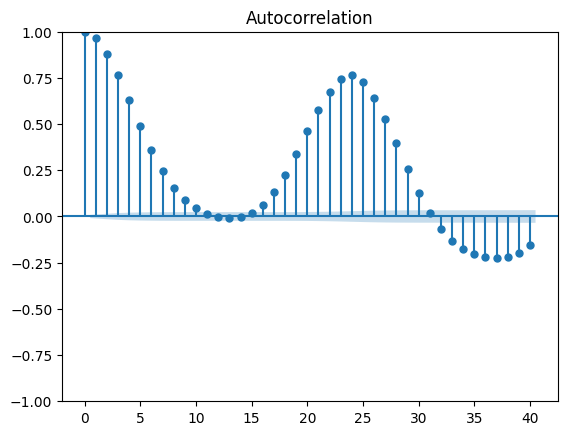

<Figure size 1000x600 with 0 Axes>

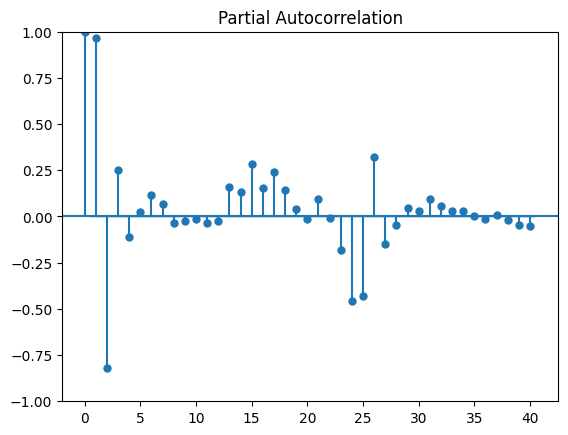

In [7]:
# Visualize ACF and PACF for the target variable
plt.figure(figsize=(10, 6))
plot_acf(y_transformed, lags=40)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(y_transformed, lags=40)
plt.show()


In [8]:
# 3. Scaling (optional): Scale the exogenous variables if necessary
scaler = StandardScaler()


In [9]:
# # Filter data for 2020
# df_2020 = df[df.index.year == 2020]
# y_2020 = df_2020[target_column]
# X_2020 = df_2020[exogenous_variables]

# # Check if there's enough data after filtering
# print(f"Size of 2020 data: {len(df_2020)} rows")

# if len(df_2020) == 0:
#     raise ValueError("No data available for the year 2020 after filtering. Check the date range or input data.")


In [10]:
# Test for stationarity using the ADF test
adf_result = adfuller(y)
if adf_result[1] > 0.05:
    y_transformed, lam = boxcox(y)  # Apply Box-Cox transformation if non-stationary
else:
    y_transformed = y

In [11]:
# Split data into train and test sets (80% train, 20% test)
print(f"Original data size: {len(df)}")
train_size = int(0.8 * len(df))
train_y, test_y = y_transformed[:train_size], y_transformed[train_size:]
train_X, test_X = X[:train_size], X[train_size:]

Original data size: 50400


In [12]:
# Scale exogenous variables after splitting
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)
print(f"Train size: {len(train_y)}, Test size: {len(test_y)}")

Train size: 40320, Test size: 10080


In [13]:
# Use auto_arima from pmdarima to get initial best parameters
print("Running auto_arima for initial parameter search...")
auto_model = pm.auto_arima(train_y,
                            exogenous_variables=train_X_scaled,
                            seasonal=True,
                            m=24,
                            stepwise=True,
                            trace=True,
                            start_p=0, max_p=1,
                            start_q=0, max_q=1,
                            start_P=0, max_P=1,
                            start_Q=0, max_Q=1,
                            suppress_warnings=True,
                            # max_order=3,
                            error_action='ignore',
                            max_d=1,
                            max_D=1,
                            # n_jobs=5, Parallel processing is disabled due incompatibility with Stepwise search
                            method="nm",
                            # information_criterion='bic',
                        )

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
print(f"Best order: {best_order}, Best seasonal order: {best_seasonal_order}")

Running auto_arima for initial parameter search...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=748606.373, Time=1.49 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=22.86 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=716334.417, Time=22.78 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=748604.373, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=723808.214, Time=2.85 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=687456.892, Time=25.37 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=690428.442, Time=23.01 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=685756.471, Time=22.28 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=716606.475, Time=24.06 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=22.01 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=667968.344, Time=22.96 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=686904.418, Time=23.26 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=709375.552, Time=2.30 sec
 ARIMA(1,1,1)(

In [14]:
# Ensure consistent datetime index and timezone (if necessary)
train_y.index = pd.to_datetime(train_y.index, utc=True)
test_y.index = pd.to_datetime(test_y.index, utc=True)
# Fit SARIMAX with auto_arima parameters
sarimax_model = SARIMAX(train_y, exog=train_X_scaled, order=best_order, seasonal_order=best_seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)
print(sarimax_result.summary())

/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:     DE_load_actual_entsoe_transparency   No. Observations:                40320
Model:                 SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -324606.654
Date:                                Sat, 14 Sep 2024   AIC                         649233.308
Time:                                        22:25:54   BIC                         649319.354
Sample:                                    01-01-2015   HQIC                        649260.534
                                         - 08-07-2019                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1593.5522     41.983     37.957      0.000    1511.267    1675.837
x2 

In [15]:
# Make predictions on the test set
predictions = sarimax_result.predict(start=test_y.index[0], end=test_y.index[-1], exog=test_X_scaled)

In [16]:
# Reverse Box-Cox transformation if applied
if 'lam' in locals():
    predictions = np.exp(np.log(predictions * lam + 1) / lam)  # Reverse transformation
    test_y = np.exp(np.log(test_y * lam + 1) / lam)

MSE: 287359865.02811927
RMSE: 16951.69209926016
MAE: 14723.682288755303
R2: -1.9687115258653893
MAPE: 29.492992115097472%
Accuracy: 11.428571428571429% with a tolerance of 5%


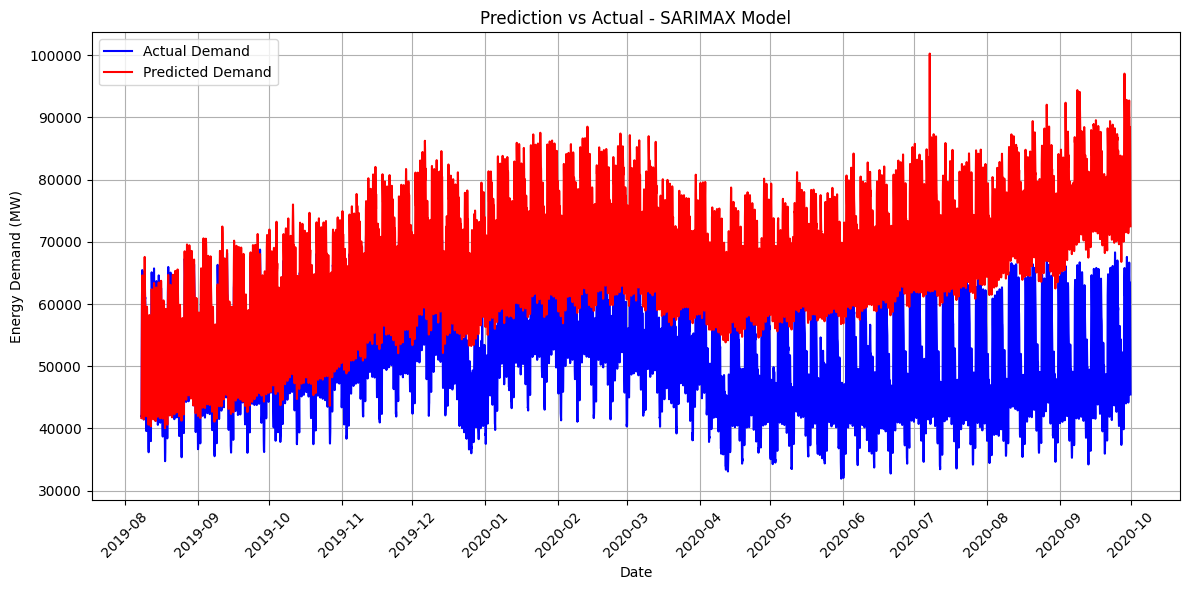

In [18]:
import importlib
import src.utils.conclusion_metrics
import src.utils.plotting
importlib.reload(src.utils.conclusion_metrics)
from src.utils.conclusion_metrics import calculate_all_metrics
importlib.reload(src.utils.plotting)
from src.utils.plotting import plot_predictions
# 7. Calculate metrics: MSE,  RMSE, MAE, R2, MAPE
test_dates = df.index[-len(test_y):]
calculate_all_metrics(y_true=test_y, y_pred=predictions)
plot_predictions( test_y, predictions, test_dates, 'Prediction vs Actual - SARIMAX Model')


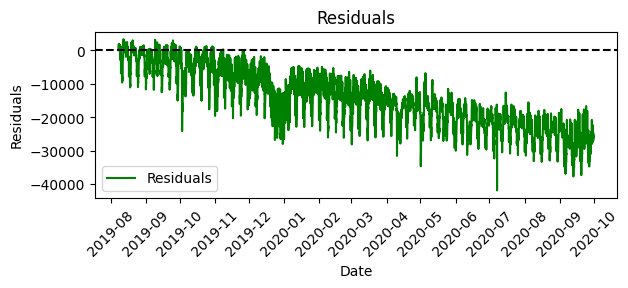

In [48]:
from src.utils.plotting import plot_residuals
residuals = test_y - predictions
plot_residuals(test_dates, residuals)